# Learning rate

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

## Learning rate finder

- PytorchにはLearning rate finderは実装されていないので自分で用意する必要がある
- 学習率=1e-8からはじめ、log scaleでミニバッチごとに学習率を増加する
- 横軸：学習率(log scale)、縦軸:損失のグラフを描画する
- 学習データ、モデル等は使わない
- モデル, train_data_loader, 損失関数, 学習率の増加係数を引数にする

In [3]:
# ================MLP自作クラス=================
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x

In [4]:
# =============自作Datasetクラス=============
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

In [5]:
# =============自作学習ループ関数=============
def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')  # 1回目のval_lossを無限大とする
    no_improve = 0 # early stoppingのカウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            
            # mini batch作成 -> 削除
    
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds = model.forward(X) 
            loss = loss_func(preds, y)
            running_loss += loss.item()
            # backward
            loss.backward()
            opt.step()
            
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                
                preds_val = model(X_val)  
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0] 
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # early ｓｔｏｐｐｉｎｇ
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            # モデルの保存
            if save_path is not None:
                state = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stoping early')
            break

    return train_losses, val_losses, val_accuracies

In [6]:
# データロード
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
images = images * (255.0 / 16.0)  # 0-16 -> 0-255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # 0-255 -> 0-1
    transforms.Normalize((0.5, ), (0.5, ))  # 0-1 -> -1-1
])

train_dataset = MyDataset(X_train, y_train, transform)
val_dataset = MyDataset(X_val, y_val, transform)

# DataLoader
bacth_size = 10
train_loader = DataLoader(train_dataset, batch_size=bacth_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=bacth_size, num_workers=2)

# Refactoring後の学習ループ
num_in = 64
num_hidden = 30
num_out = 10
model = MLP(num_in, num_hidden, num_out)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
# train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

In [7]:
# =============自作Learning rate finderのクラス=============
def lr_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr = 1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
        X, y = data

        opt.zero_grad()
        # forward
        preds = model.forward(X) 
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)
        
        # backward
        loss.backward()
        opt.step()

        lr *= lr_multiplier

        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break

    return lrs, losses

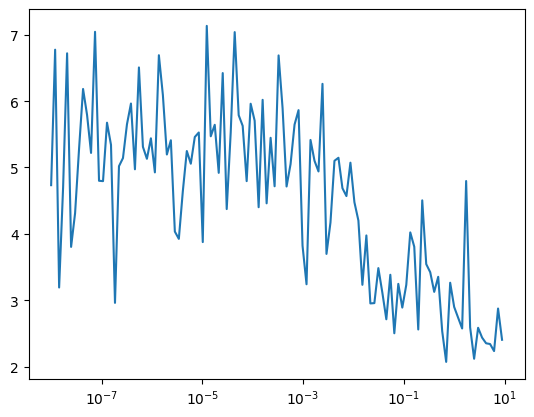

In [9]:
# Learning rate finder
lrs, losses = lr_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)

# 描画　-> 1e-2〜1e-1の範囲のlrを使えば良いのがわかる
plt.plot(lrs, losses)
plt.xscale('log')

## Learning rate schesduler

- torch.optim.lr_schedulerにて様々なschedulerを提供
    1. インスタンス生成
        - 第一引数にoptimizerオブジェクトを渡す
        - その他のパラメータを引数に渡す
    2. .step()メソッドで、optimizerのlearning rateを更新する
    - StepLR
        - optimizer: optimizerオブジェクト
        - step_size: 学習率を減少させるstep数
        - gamma: 学習率の減衰率。step_sizeのepoch毎に学習率をgammaに乗ずる
    - CosineAnnealingLR
        - optimizer: optimizerオブジェクト
        - T_max: 最大値から最小値になるまでのイテレーション（cos波のT/2周期）

In [10]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

### StepLR

In [11]:
# モデル初期化
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)

# StepLR
# step_sizeはepoch数と同義、gammaは学習率の減衰率
scheduler = StepLR(opt, step_size=30, gamma=0.1)

for param_group in opt.param_groups:
    print(param_group['lr'])
for epoch in range(30):
    scheduler.step()
for param_group in opt.param_groups:
    print(param_group['lr'])

0.1
0.010000000000000002


/usr/local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


### CosineAnnealingLR

In [12]:
# モデル初期化
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)

# CosineAnnealingLR
# T_max=50とすると、cos curveの周期は100になる
scheduler = CosineAnnealingLR(opt, T_max=50)
lrs = []

for epoch in range(150):
    scheduler.step()
    lrs.append(opt.param_groups[0]['lr'])

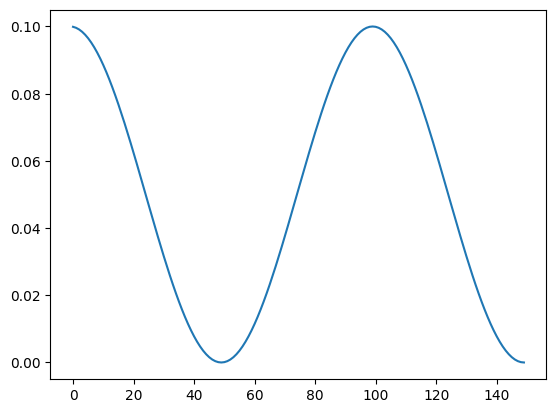

In [13]:
plt.plot(lrs)

### learning rate schedulerを学習ループに組み込む

In [14]:
# learning rate schedulerを学習ループに組み込む
# =============自作学習ループ関数=============
def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')  # 1回目のval_lossを無限大とする
    no_improve = 0 # early stoppingのカウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            
            # mini batch作成 -> 削除
    
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds = model.forward(X) 
            loss = loss_func(preds, y)
            running_loss += loss.item()
            # backward
            loss.backward()
            opt.step()
            
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                
                preds_val = model(X_val)  
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0] 
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        # early ｓｔｏｐｐｉｎｇ
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            # モデルの保存
            if save_path is not None:
                state = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stoping early')
            break

        # shcedularの機能追加
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [ ]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=30, gamma=0.1)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, loss_func=F.cross_entropy, num_epoch=100, scheduler=scheduler)

epoch: 0: train error: 1.1287445692966382, validation error: 0.340499658551481, validation accuracy: 0.9138888782925076
epoch: 1: train error: 0.2789076770034929, validation error: 0.19643933170785507, validation accuracy: 0.9249999937083986
epoch: 2: train error: 0.1779691990490796, validation error: 0.14967881153441137, validation accuracy: 0.9444444361660216
epoch: 3: train error: 0.14392982078586808, validation error: 0.12202881092930006, validation accuracy: 0.9583333283662796
epoch: 4: train error: 0.113422490158377, validation error: 0.1694634642270911, validation accuracy: 0.9444444378217062
epoch: 5: train error: 0.10154673466846968, validation error: 0.13936329883290455, validation accuracy: 0.9527777714861764
epoch: 6: train error: 0.09208666940523674, validation error: 0.1018363870615657, validation accuracy: 0.972222218910853
epoch: 7: train error: 0.07377822905416703, validation error: 0.12579609209205955, validation accuracy: 0.9611111051506467
epoch: 8: train error: 0.0